## Imports

In [2]:
import os

import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as tfk
from tensorflow.compat.v1.keras.initializers import RandomNormal, TruncatedNormal
from tensorflow.compat.v1.keras.layers import (Input, Dense, Activation, Layer, Lambda,
                                     Concatenate)
from tensorflow.compat.v1.keras.models import Model, load_model
from tensorflow.compat.v1.keras.optimizers import Adam

from models import ConvNet, SoftBinaryDecisionTree
from models.utils import brand_new_tfsession, draw_tree
from tensorflow.keras.callbacks import EarlyStopping, Callback

tf.disable_v2_behavior()


sess = brand_new_tfsession()

Instructions for updating:
non-resource variables are not supported in the long term


## Dataset

In [3]:
# load MNIST data
mnist = tf.keras.datasets.mnist
# TODO
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# add channel dim
# TODO
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

# hold out last 10000 training samples for validation
# TODO:
x_valid, y_valid = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)
# TODO: (50000, 28, 28, 1) (50000,) (10000, 28, 28, 1) (10000,) (10000, 28, 28, 1) (10000,)

(50000, 28, 28, 1) (50000,) (10000, 28, 28, 1) (10000,) (10000, 28, 28, 1) (10000,)


In [4]:
# retrieve image and label shapes from training data
img_rows, img_cols, img_chans = x_train.shape[1:]
n_classes = np.unique(y_train).shape[0]

print(img_rows, img_cols, img_chans, n_classes)

28 28 1 10


In [5]:
# convert labels to 1-hot vectors
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

print(y_train.shape, y_valid.shape, y_test.shape)

(50000, 10) (10000, 10) (10000, 10)


In [6]:
# normalize inputs and cast to float
x_train = (x_train / np.max(x_train)).astype(np.float32)
x_valid = (x_valid / np.max(x_valid)).astype(np.float32)
x_test = (x_test / np.max(x_test)).astype(np.float32)

## Neural Network

In [7]:
nn = ConvNet(img_rows, img_cols, img_chans, n_classes)

In [8]:
nn = ConvNet(img_rows, img_cols, img_chans, n_classes)
nn.maybe_train(data_train=(x_train, y_train),
               data_valid=(x_valid, y_valid),
               batch_size=16, epochs=12)
nn.evaluate(x_train, y_train)

Loading trained model from assets/nn-model.hdf5.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
accuracy: 99.93% | loss: 0.003023036504798038


In [9]:
nn.evaluate(x_valid, y_valid)
nn.evaluate(x_test, y_test)

accuracy: 99.14% | loss: 0.03457641640711636
accuracy: 99.27% | loss: 0.02784054759651358


### Extraction of soft labels for distillation

In [10]:
y_train_soft = nn.predict(x_train)
y_train_soft.shape

(50000, 10)

## Binary Soft Decision Tree

Flatten dataset in advance

((50000, 784), (10000, 784), (10000, 784))

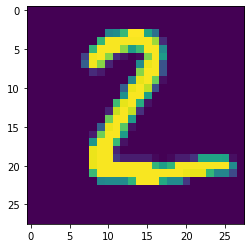

In [11]:
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_valid_flat = x_valid.reshape((x_valid.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_test_flat.reshape((x_test_flat.shape[0], img_rows, img_cols))[1])

x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape

### Hyperparameters
* `tree_depth`: as denoted in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)], depth is in terms of inner nodes (excluding leaves / indexing depth from `0`)
* `penalty_strength`: regularization penalty strength
* `penalty_decay`: regularization penalty decay: paper authors found 0.5 optimal (note that $2^{-d} = 0.5^d$ as we use it)
* `ema_win_size`: scaling factor to the "default size of the window" used to calculate moving averages (growing exponentially with depth) of node and path probabilities
* `inv_temp`: scale logits of inner nodes to "avoid very soft decisions" [[paper](https://arxiv.org/pdf/1711.09784.pdf)]
    * pass `0` to indicate that this should be a learned parameter (single scalar learned to apply to all nodes in the tree)
* `learning_rate`: hopefully no need to explain, but let's be cool and use [Karpathy constant](https://www.urbandictionary.com/define.php?term=Karpathy%20Constant) ([source](https://twitter.com/karpathy/status/801621764144971776)) :D as default in `tree.__init__()`
* `batch_size`: we use a small one, because with increasing depth and thus amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimization properties

In [12]:
n_features = img_rows * img_cols * img_chans
tree_depth = 4
penalty_strength = 1e+1
penalty_decay = 0.25
ema_win_size = 1000
inv_temp = 0.01
learning_rate = 5e-03
batch_size = 4

### Regular training with hard labels

In [13]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Use fn_output_signature instead
Built tree has 16 leaves out of 31 nodes


In [14]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es])

Loading trained model from assets/non-distilled/tree-model.
INFO:tensorflow:Restoring parameters from assets/non-distilled/tree-model


In [15]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

accuracy: 91.21% | loss: 7.225527998542786
accuracy: 90.59% | loss: 7.2228197029113765


### Distillation: training with soft labels

In [16]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Built tree has 16 leaves out of 31 nodes


In [17]:
epochs = 50

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train_soft), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es], distill=True)

Loading trained model from assets/distilled/tree-model.
INFO:tensorflow:Restoring parameters from assets/distilled/tree-model


In [18]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

accuracy: 92.65% | loss: 7.304763636016846
accuracy: 92.24% | loss: 7.300975444030762


### Visualizing learned parameters

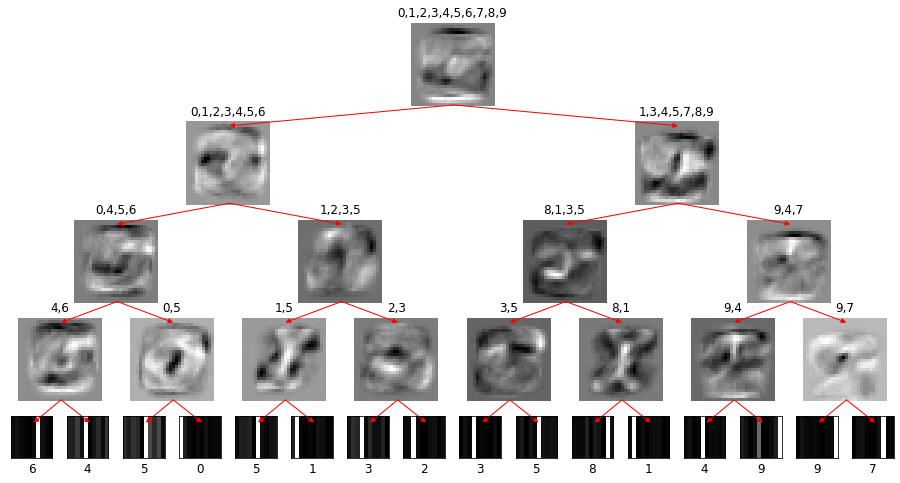

In [19]:
draw_tree(sess, tree, img_rows, img_cols, img_chans)

#### How to read the visual

Exactly as in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)]:
* Number **below** any **leaf** denotes `argmax()` of learned distribution, thus final static **prediction** of the (bigot, not expert!) leaf.
* Numbers **above** any **inner node** denote the **set of possible predictions** in the sub-tree of the given node.

## A TERAZ WIEKSZA GLEBOKOSC

### Visualizing decision path

In [20]:
digit = 9

# get (reproducibly) pseudo-random example of chosen digit
np.random.seed(0)
sample_index = np.random.choice(np.where(np.argmax(y_test, axis=1)==digit)[0])
input_img = x_test[sample_index]

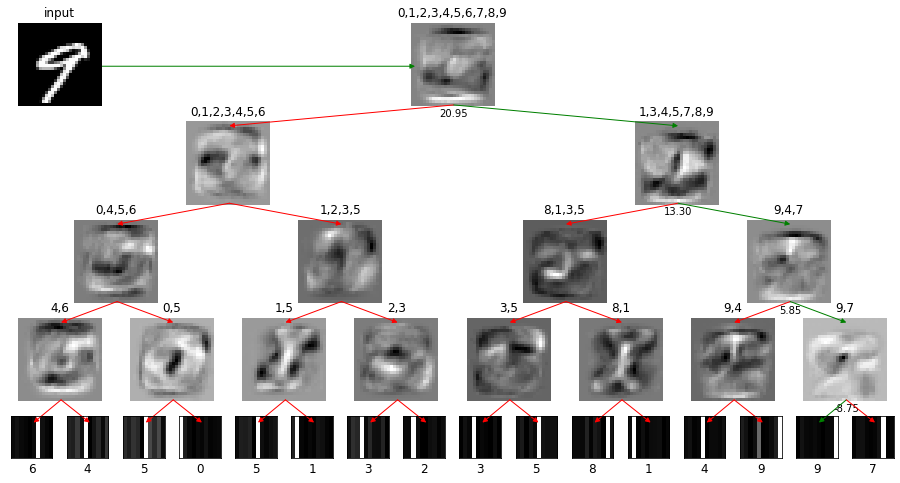

In [21]:
draw_tree(sess, tree, img_rows, img_cols, img_chans, input_img=input_img)

#### How to read the visual

* The <span style="color:green">**maximum probability path**</span> leading **to final prediction** is now denoted by <span style="color:green"> **green arrows**</span>
* Number **below** any given **inner node** on this <span style="color:green">**path**</span> denotes the **pre-activation logit** $ = (\beta (\mathbf{xw}_i + b_i))$.
    * This is basically just a **biased** ($b_i$) and **scaled** ($\beta$) **correlation** of **input** ($\mathbf{x}$) with the given **mask** ($\mathbf{w}_i$).
    * From the definition of $\sigma$ activation function, the choice of branch breaks around `0`.
    * From the definition of **branching** in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)], **negative** correlations branch **to the left**, while **positive** correlations branch **to the right**.

<img src="assets/img/branching.png" width="35%"/>

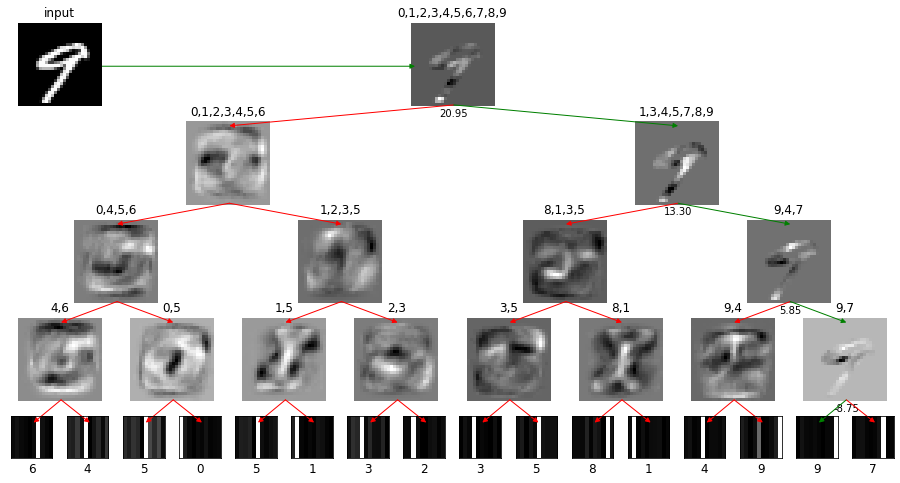

In [22]:
draw_tree(sess, tree, img_rows, img_cols, img_chans, input_img=input_img, show_correlation=True)

#### How to read the visual

* On the <span style="color:green">**maximum probability path**</span> there are now **correlations** of the **input image** with the **node masks**.
* The **homogeneous area** gives a frame of reference for color of `0`s.
    * It always corresponds to the **black area in the input image**, but due to lack of normalization (yes, I'm the lazy one here), it ends up as different shade of gray in each subplot.
    * All **lighter pixels** from this correspond to **positive correlation coefficients**.
    * All **darker pixels** correspond to **negative correlation coefficients**.

_Note: In the last input-masked kernel on the path to prediction, notice how model recognizes `9`s from `7`s._

# Final word

If you're reading this, I believe you are interested in this implementation, so please don't hesitate to **try it yourself** :)

* tune hyperparameters of the tree model
    * try out different depths and penalty parameters (strength, decay)
    * implement dynamic inverse temperature ($\beta$), scheduled as a function of training step / epoch
* try out different dataset, the approach is generic enough!

In [23]:
tf

<module 'tensorflow.compat.v1' from 'c:\\users\\comarch\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\tensorflow\\_api\\v2\\compat\\v1\\__init__.py'>